## Basic flow in an examplary MIR - classification research task

This notebook is designed to demonstrate basic/common flow of processes in an MIR classification task: "Automatic instrument recognition". The content should be considered as educational material rather than research material. Various segments of it aim to raise a question for discussion rather than presenting a state-of-the-art solution. Indeed, the process has a problem that we later observe and discuss close to the end, try spotting it yourself while reading the code.
![MIR classification task basic flow](https://raw.githubusercontent.com/MTG/MIRCourse/master/notebooks/figures/MIRresearchOverview_1.png)

**In-class discussion topics:**
* Defining the problem and the context, data space, reqirements, specifications <-> Literature review
* Curating a representative research dataset (available datasets, common/standard representation formats)
* Designing the flow, algorithms/processes/methods and implementation
* Evaluation

**Reading list:** https://sites.google.com/site/mirspring2018/my-reading-list


## A classification task: instrument recognition

* Let's pick one of the standard MIR tasks: automatic instrument recognition, and limit our context as monophonic isolated notes recordings.
* The task is a classification task; hence, our first aim is gather a set of isolated note recordings for various instruments with instrument labels. We will be using (downloading) samples from an existing recording collection ([Mridangam Stroke Dataset](https://zenodo.org/record/1265188#.Xh3v28hKg2x))
* Our algorithmic design will be based on the standard flow of feature extraction followed by feeding the data to a classifier  (see figure below)
* At the end, we will use standard evaluation measures of automatic classification to test our approach.

In [0]:
#If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
  !pip install essentia

In [0]:
#Basic imports
import os
import matplotlib.pyplot as plt
import essentia.standard as ess
import essentia
import numpy as np
import IPython.display as ipd

## Collecting raw data and investigating its nature

### Downloading dataset files

In [286]:
#This cell downloads a subset of the UIOWA:MIS dataset
import urllib.request
import zipfile
import os, sys,shutil

#Links for some of files in the UIOWA:MIS dataset
url = 'https://zenodo.org/record/1265188/files/mridangam_stroke_1.0.zip?download=1'

print('Downloading file ')
filename = url.split('/')[-1]
urllib.request.urlretrieve(url,filename)
#Unzipping to a specific folder
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall()
zip_ref.close()
os.remove(filename)#Removing the zip file
print('Data downloaded and unzipped')
      

Data downloaded and unzipped


**Collect file lists for each instrument**

In [0]:
main_data_dir = 'mridangam_stroke_1.0'
inst_files_tonic = dict()#dictionary containing for each instrument a list that carries dictionaries
inst_files_stroke = dict()#dictionary containing for each instrument a list that carries dictionaries
for root, dirs, files in os.walk(main_data_dir):
    for file in files:
        #Let's only keep forte recordings indicated with .ff. in the file name
        if (file.endswith('.wav')):
            file_name = os.path.join(root,file)
            stroke = file.split('_')[4]#instrument name is coded in the filename
            stroke = stroke.split('-')[0]
            tonic = file.split('-')[1]
            if(len(stroke) > 0 or len(tonic)):#avoid MACOS files that start with ._
                files_stroke = inst_files_stroke.get(stroke)
                files_tonic = inst_files_tonic.get(tonic)
                if files_stroke == None:
                    files_stroke = [file_name]
                else:
                  files_stroke.append(file_name)
                  
                if files_tonic == None:
                    files_tonic = [file_name]
                else:
                    files_tonic.append(file_name)
                inst_files_stroke[stroke] = files_stroke
                inst_files_tonic[tonic] = files_tonic  


Now we have our dataset splitted in two different dictionaries: stroke and tonic. First we verify how much data we have for the different classes of strokes and tonics:

In [288]:
print("STROKE")
total = 0
for st in (inst_files_stroke):
  print(f"{st} = {len(inst_files_stroke[st])}")
  total += len(inst_files_stroke[st])
print(f"TOTAL = {total}")


print("\nTONIC")
total = 0
for to in (inst_files_tonic):
  print(f"{to} = {len(inst_files_tonic[to])}")
  total += len(inst_files_tonic[to])
print(f"TOTAL = {total}")


STROKE
num = 497
bheem = 49
thi = 2213
dheem = 468
thom = 642
tha = 1176
dhin = 482
tham = 374
ta = 931
cha = 330
TOTAL = 7162

TONIC
dsh = 1495
d = 916
e = 1100
c = 1129
csh = 1197
b = 1325
TOTAL = 7162


Now that we have gather the dataset, we can now focus designing the basic flow for our classification task

![Basic flow](https://raw.githubusercontent.com/MTG/MIRCourse/master/notebooks/figures/classification_basicFlow.png)

### Investigating and preprocessing raw data

It is often very useful to first check a few samples from the dataset to decide what preprocessing steps are required.


Sample waveform plots


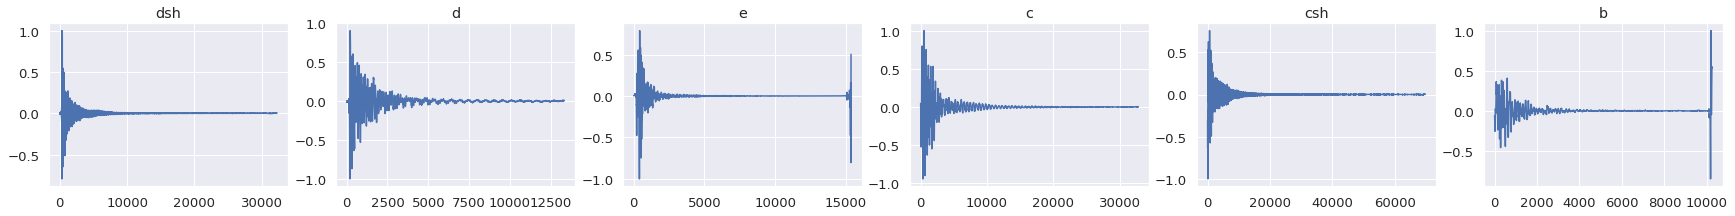

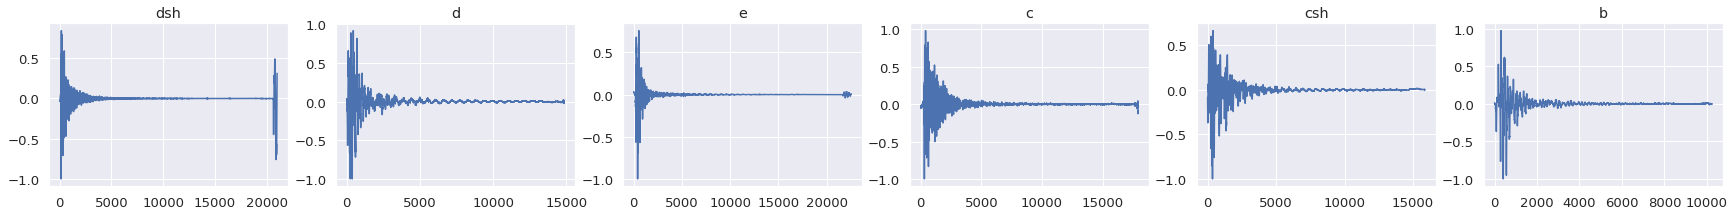

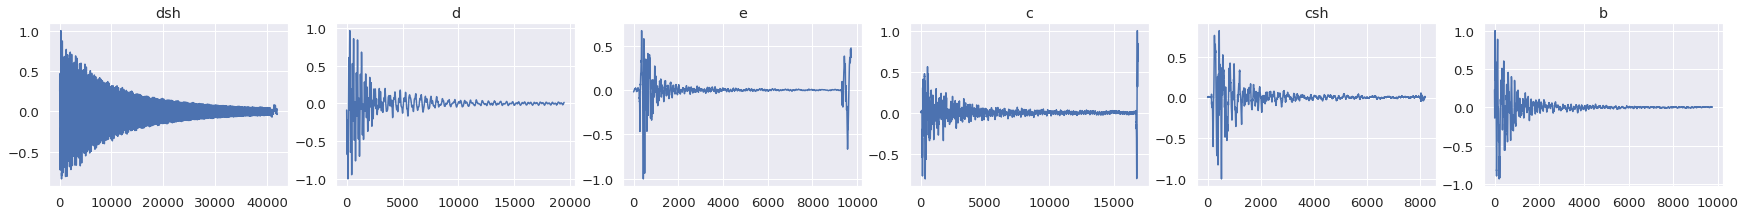

In [289]:
# Raw-data preprocess analysis parameters
fs = 44100

num_tonic = len(inst_files_tonic.keys())
print("Sample waveform plots")
plt.figure(1, figsize=(5 * num_tonic, 3))
num_tonic = len(inst_files_tonic.keys())
file_indexes = [0, 1, 2]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_tonic, 3))
    for i, tonic in enumerate(inst_files_tonic.keys()):
      sample_file = inst_files_tonic[tonic][file_ind_inlist]
      x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
      x = x / np.max(np.abs(x))           # Normalization
      plt.subplot(1,num_tonic,(i+1))
      plt.plot(x)
      plt.title(tonic)

We can see there is little noise at the end of the samples. Therefore we should get rid of the noise, in order to have a good tonic detection. 

Because we want to do tonic classification, it is important to know that the pitch content in percussive elements it is embedded in the sustain and release of the envelope. Not in the attack which contains higher frequencies.

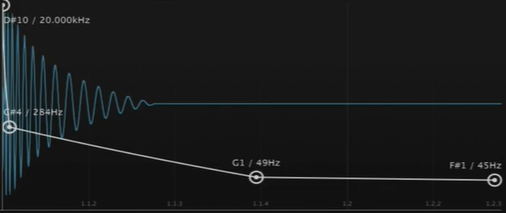

Lets listen to some of the excerpts that we have plot, in order to decide what should we preprocess

In [290]:
sample_file = inst_files_tonic['dsh'][2]
x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
x = x / np.max(np.abs(x))
print(f"File: {sample_file}")
ipd.display(ipd.Audio(data=x, rate=fs))

sample_file = inst_files_tonic['d'][2]
x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
x = x / np.max(np.abs(x))
print(f"File: {sample_file}")
ipd.display(ipd.Audio(data=x, rate=fs))

sample_file = inst_files_tonic['csh'][0]
x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
x = x / np.max(np.abs(x))
print(f"File: {sample_file}")
ipd.display(ipd.Audio(data=x, rate=fs))

File: mridangam_stroke_1.0/D#/228639__akshaylaya__bheem-dsh-015.wav


File: mridangam_stroke_1.0/D/228559__akshaylaya__thom-d-036.wav


File: mridangam_stroke_1.0/C#/227448__akshaylaya__thi-csh-205.wav


Listening to the examples a taking a look to their plots in the above matrix of plots, we perceive that the at the end of the excerpts it appears noise and some clips that we need to delete in order to measure the key of the stroke in an optimal way.


### Preprocessing of raw data: Segmentation, splitting, alignment,... 

While common preprocessing steps (such as amplitude normalisation) exist, there is often some dataset and task specific preprocessing tasks required for grouping, cleaning, and format change. 

Taking into account what we have mentioned before. The best way to identify the tonic is by doing the following preprocessing:
- ***Delete the attack wich has high frequency content***.
 This is done by running 'Onset Detection function' and deleting the first 10ms of the sample, because mridangam it is an instrument with sharp attack.
- ***Delete last part of the excerpt to delete noise & delete last parto of the excerpt with low amplitude in the release***
 Done by checking maximum amplitude of part of the sample that starts at 5/6 and last two periods of a 100Hz wave. This is to ensure that we are going to measure the maximum in that last part of the sample (because the key should not be lower than 100Hz, and therefore we ensure to read the maximum). Comparing this value with the amplitude of the whole last 1/6th of the sample we decide to delete this last part or not.



In [0]:
# Raw-data preprocess analysis parameters
hopSize = 4096 * 2
V_threshold = 0.01 #waveform threshold value
T_sample = int(0.01*44100*2) # nº of sample that correspond to 4 periods of a wave of 100Hz 
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "hopSize":hopSize, "T_sample":T_sample}

In [0]:
#Function definition
def clean_file(filename,params):
    '''Function to clear last part of the samples and silent samples
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()

    # ---------------------- Attack Removal -----------------------------------#
    od = ess.OnsetDetection(method='hfc')

    # Let's also get the other algorithms we will need, and a pool to store the results
    w = ess.Windowing(type = 'hann')
    fft = ess.FFT() # this gives us a complex FFT
    c2p = ess.CartesianToPolar() # and this turns it into a pair (magnitude, phase)
    pool = ess.essentia.Pool()

    # Computing onset detection functions.
    for frame in ess.FrameGenerator(x, frameSize = 1024, hopSize = 512):
        mag, phase, = c2p(fft(w(frame)))
        pool.add('features.hfc', od(mag, phase))

    # Phase 2: compute the actual onsets locations
    onsets = ess.Onsets()

    onsets_hfc = onsets(essentia.array([ pool['features.hfc'] ]),[ 1 ])

    #Attack removal
    if onsets_hfc[0]*44100 < len(x)/2:
      k_5ms = int(0.005*fs)
      x = x[int(onsets_hfc[0]*fs)+k_5ms:]


    # ------------------ Noise & Release Removal -----------------------------#
    if len(x)>2:  # Check if file is empty
    
      # 3/4th sample of the excerpt
      x_end_sample = int(3*len(x)/4)

      #Check if there is noise at the end of the excerpt
      if max(x[x_end_sample : x_end_sample+T_sample]) < max(x[x_end_sample:]):
        x = x[:len(x)-int(len(x)/4)]
      #Check last part excerpt is too low  
      elif max(x[x_end_sample : x_end_sample+T_sample]) < V_threshold:
        x = x[:len(x)-int(len(x)/4)]

    return x

We apply our clean_file function and plot the same excerpts as the ones plotted before to verify the operation of the function 

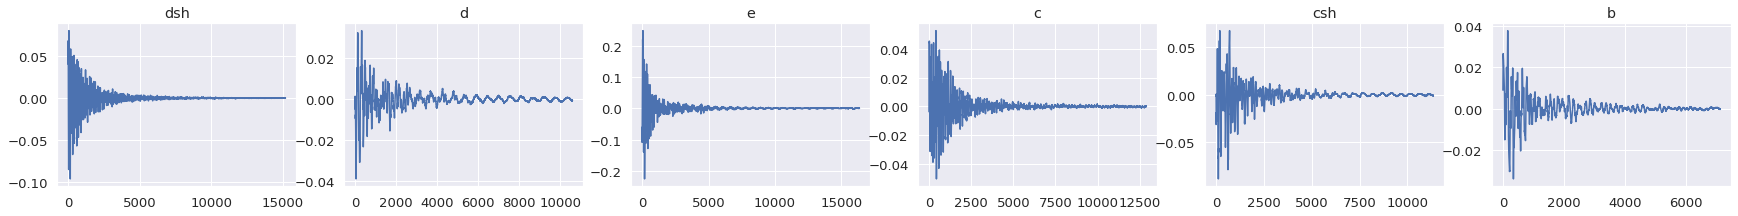

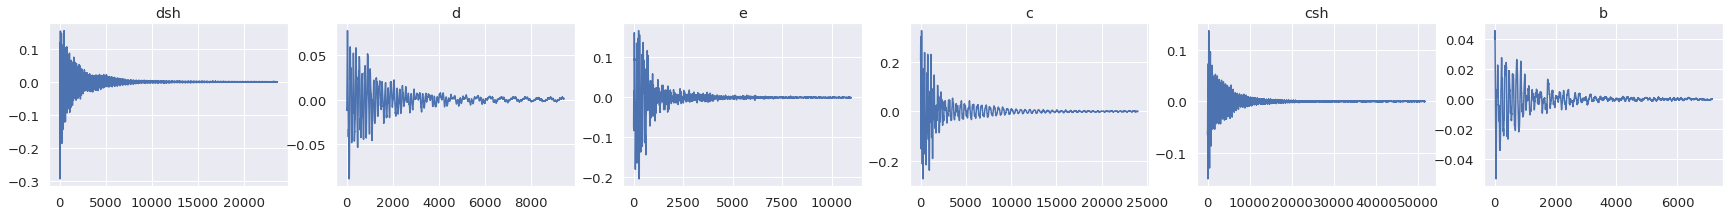

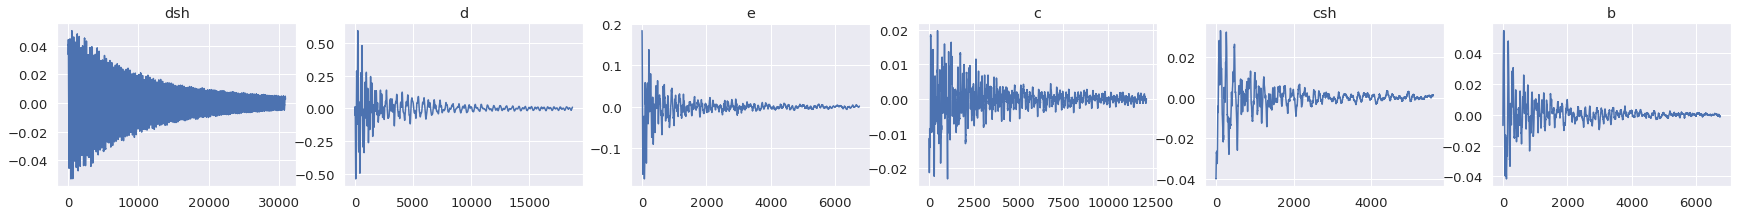

In [293]:
num_tonic = len(inst_files_tonic.keys())
file_indexes = [0,1,2]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_tonic, 3))
    for i, tonic in enumerate(inst_files_tonic.keys()):
      sample_file = inst_files_tonic[tonic][file_ind_inlist]
      x = clean_file(sample_file,params)
      plt.subplot(1,num_tonic,(i+1))
      plt.plot(x)
      plt.title(tonic)


Taking a look to the plots we see that clean_file function is working fine.

Therefore, the next step is to delete the attack of the excerpts

The decision boundaries look fine, let's use the function to 
* clean the excerpts 
* and save new excerpts in a new folder

In [294]:
segments_dir = os.path.join('mridangam_tonic')
if not os.path.exists(segments_dir):#creating the directory
    os.mkdir(segments_dir)

segment_files = []
for tonic, files in inst_files_tonic.items():
    file_count = 0
    for sample_file in files:
        x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
        #Clean excerpt for tonic classification
        x = clean_file(sample_file,params)  
        #Check if an excerpt is empty and remove it
        if max(x)<V_threshold:
          os.remove(sample_file)
          print(f"File: {sample_file} removed. Silent sample")
        else:
          x = x / np.max(np.abs(x)) #Normalization
          filename = os.path.join(segments_dir, tonic + '_' + str(file_count) + '.wav')
          ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x)
          file_count +=1
          segment_files.append(filename)

File: mridangam_stroke_1.0/C#/227067__akshaylaya__tha-csh-070.wav removed. Silent sample


In [295]:
#If required, you can use this cell to delete all files in a given folder
def delete_files_in_dir(dir_name):
    '''Deleting all files in a directory
    '''
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            file_name = os.path.join(root,file)
            os.remove(file_name);print(file_name, 'removed');

delete_files_in_dir('mridangam_stroke_1.0')

mridangam_stroke_1.0/D#/229138__akshaylaya__num-dsh-127.wav removed
mridangam_stroke_1.0/D#/229017__akshaylaya__num-dsh-019.wav removed
mridangam_stroke_1.0/D#/228639__akshaylaya__bheem-dsh-015.wav removed
mridangam_stroke_1.0/D#/229754__akshaylaya__thi-dsh-191.wav removed
mridangam_stroke_1.0/D#/229850__akshaylaya__thi-dsh-287.wav removed
mridangam_stroke_1.0/D#/228712__akshaylaya__dheem-dsh-024.wav removed
mridangam_stroke_1.0/D#/230110__akshaylaya__thom-dsh-103.wav removed
mridangam_stroke_1.0/D#/228626__akshaylaya__bheem-dsh-002.wav removed
mridangam_stroke_1.0/D#/229277__akshaylaya__tha-dsh-004.wav removed
mridangam_stroke_1.0/D#/228806__akshaylaya__dhin-dsh-007.wav removed
mridangam_stroke_1.0/D#/229592__akshaylaya__thi-dsh-029.wav removed
mridangam_stroke_1.0/D#/230060__akshaylaya__thom-dsh-053.wav removed
mridangam_stroke_1.0/D#/228905__akshaylaya__dhin-dsh-106.wav removed
mridangam_stroke_1.0/D#/229309__akshaylaya__tha-dsh-036.wav removed
mridangam_stroke_1.0/D#/229551__akshay

## Feature extraction 

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

MusicExtractor extracts three types of features: low level, tonic and rythmic features.

For this task rythmic features are not important. Therefore we are going to check tonal and low level features.

Let's first run it for a file and check its output:

In [0]:
import essentia.standard as es

#Running music extractor for a file:
file = segment_files[0]#simply pick the first file in the list
features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  tonalStats=['mean', 'stdev'],
                                                  lowlevelStats = ['mean', 'stdev','min','max'])(file)

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [297]:
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() 
if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

scalar_tonal_descriptors = [descriptor for descriptor in features.descriptorNames()
 if 'tonal' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_tonal_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.max', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.min', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.max', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.min', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.max', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.min', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.max', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.min', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.max', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.min', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.max', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.min', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.max', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_c

So, the characteristics shown for tonal features do not seem relevant for this task therefore we are going to proceed only with low level features.

Running musicextractor for all files, keeping a subset of features.

A frame size of 2048 is going to be enought for this task, because our mridangam tonic will be around 150-500Hz. Having a frame size of 2048 we obtain a frequency resolution of:

\begin{equation*} 
44100/2048 = 21.53 Hz
\end{equation*}

So in case of having a tonic of 150Hz and we want to differentiate it from a semitone above (because we to differentiate between differences of semitones (b c csh d dsh e) this would be a difference of (150Hz*1.059(semitone)=158.85) 58.85 Hz. Therefore we have enough frequency resolution for this task.

 writing to an output file: data_lowlevel_2048_mean_stdev_min_max_5ms.csv

In [298]:
#Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = os.path.join(segments_dir,'data_lowlevel_2048_mean_stdev_min_max_5ms.csv')
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['tonic']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for file in segment_files:
        if '.wav' in file:
            file_count +=1
            if file_count % 20 == 0:#print name of a file every 20 files
                print(file_count, "files processed, current file: ",file)
            features, features_frames = es.MusicExtractor(lowlevelSilentFrames='drop',
                                                          lowlevelFrameSize = 2048,
                                                          lowlevelHopSize = 1024,
                                                          lowlevelStats = ['mean', 'stdev','min','max'])(file)
            selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
            instrument = file.split('/')[-1].split('_')[0].lower()#class information
            line2write = str(selected_features)[1:-1] + ',' + instrument + '\n'
            writer.write(line2write)
print("A total of ",file_count, "files processed")

20 files processed, current file:  mridangam_tonic/dsh_19.wav
40 files processed, current file:  mridangam_tonic/dsh_39.wav
60 files processed, current file:  mridangam_tonic/dsh_59.wav
80 files processed, current file:  mridangam_tonic/dsh_79.wav
100 files processed, current file:  mridangam_tonic/dsh_99.wav
120 files processed, current file:  mridangam_tonic/dsh_119.wav
140 files processed, current file:  mridangam_tonic/dsh_139.wav
160 files processed, current file:  mridangam_tonic/dsh_159.wav
180 files processed, current file:  mridangam_tonic/dsh_179.wav
200 files processed, current file:  mridangam_tonic/dsh_199.wav
220 files processed, current file:  mridangam_tonic/dsh_219.wav
240 files processed, current file:  mridangam_tonic/dsh_239.wav
260 files processed, current file:  mridangam_tonic/dsh_259.wav
280 files processed, current file:  mridangam_tonic/dsh_279.wav
300 files processed, current file:  mridangam_tonic/dsh_299.wav
320 files processed, current file:  mridangam_ton

## Analysis and preprocessing of features

All extracted features are saved in data.csv. Columns represent features and rows files/samples. This is a typical format in a large number of machine learning datasets (see a few of the dataset here: https://archive.ics.uci.edu/ml/index.php or other "Data Science" examples on the web).  

***The use of a common format for data representation is beneficial in both making use of existing tools/libraries (such as Pandas) and contributing to the community with resources that are easy to use.***

Let's load the data and start investigating the features. We can use Pandas (a package largely used in data science) to read data and access statistical description of the features. 

In [0]:
import pandas as pd

In [17]:
#Read data
data_file = segments_dir + '/data_lowlevel_2048_mean_stdev_min_max_5ms.csv'
data = pd.read_csv(data_file)
#Let's see the first lines of our data
data.head()
data.shape

(7161, 165)

All features are represented with columns, and the last column ('instrument') carries the class information.

Always check if your data involves NaN values and clean them (by simply removing the sample, or replacing the NaN value by a real value (such as the median of that feature)).

In [18]:
data.isnull().sum().sum()#sums a matrix of True/False values obtained by checking if each value is Nan

0

**Observation:** No NaN value, proceed ..

We can plot samples on two-dimensional feature spaces to check if features are discriminative for those classes. Here is an example:

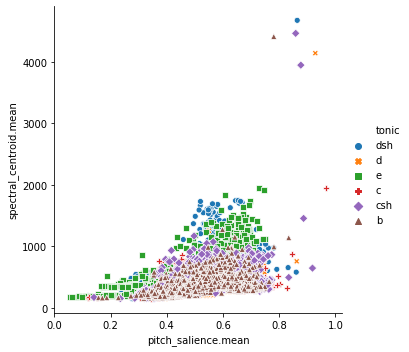

In [19]:
import seaborn as sns
# hue -> Grouping variable that will produce elements with different colors
# style -> Grouping variable that will produce elements with different styles
sns.relplot(x = "pitch_salience.mean", y = "spectral_centroid.mean", 
            hue = "tonic", style = "tonic", data = data);

The Seaborn package includes some very useful plotting functions that facilitate such visual inspections. Here is another example: this time producing plots **for the last 6 features**, creating all combinations to form 2-dimensional feature spaces representing the samples from different classes

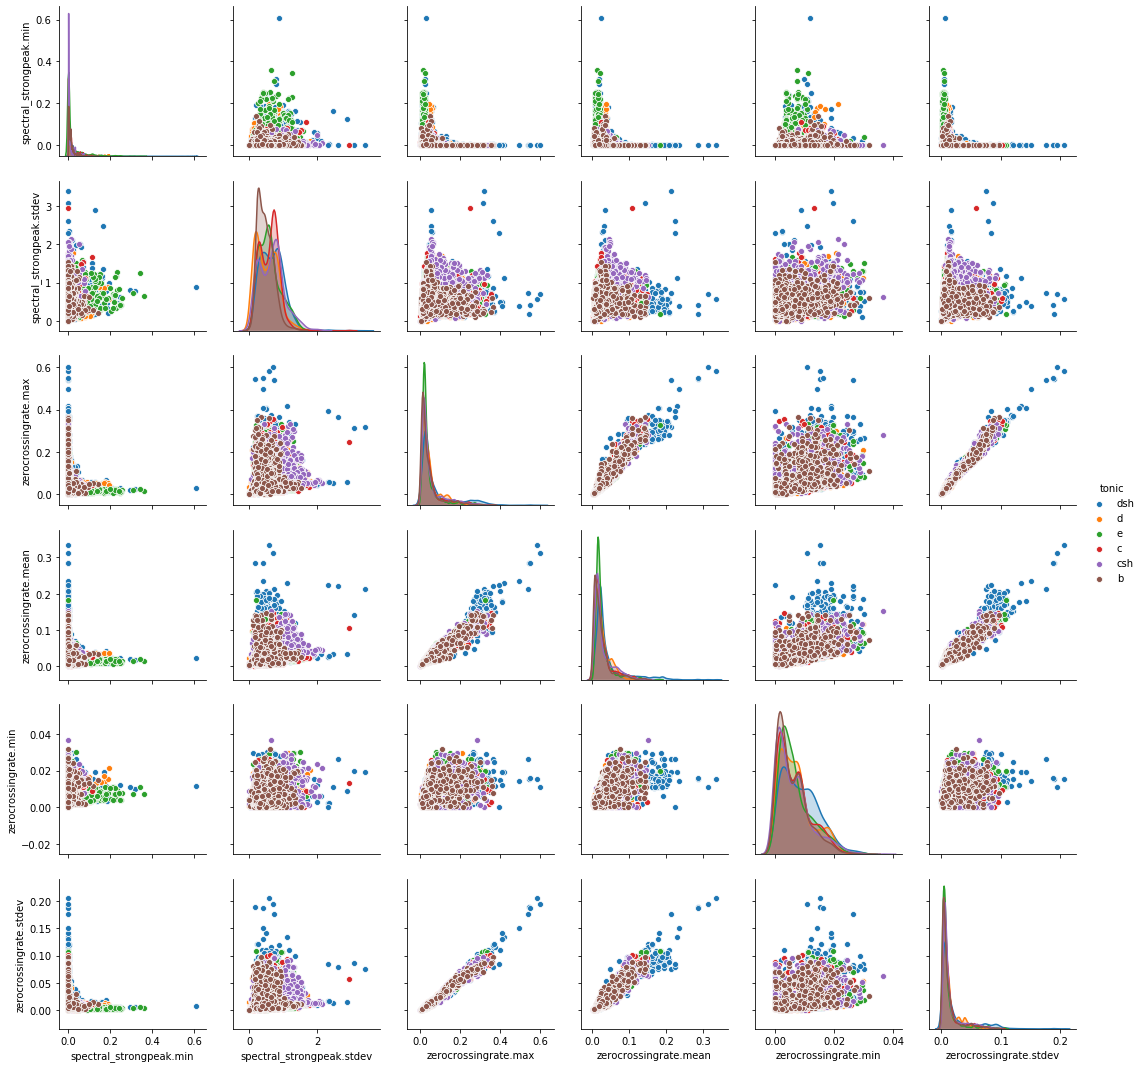

In [20]:
sns.pairplot(data.iloc[:, -7:], hue = "tonic");

As the next step, having a look at descriptive statistics of the features would be useful. Let's do that:

In [21]:
#Descriptive statistics of the features:
data.describe()

,average_loudness,barkbands_crest.max,barkbands_crest.mean,barkbands_crest.min,barkbands_crest.stdev,barkbands_flatness_db.max,barkbands_flatness_db.mean,barkbands_flatness_db.min,barkbands_flatness_db.stdev,barkbands_kurtosis.max,barkbands_kurtosis.mean,barkbands_kurtosis.min,barkbands_kurtosis.stdev,barkbands_skewness.max,barkbands_skewness.mean,barkbands_skewness.min,barkbands_skewness.stdev,barkbands_spread.max,barkbands_spread.mean,barkbands_spread.min,barkbands_spread.stdev,dissonance.max,dissonance.mean,dissonance.min,dissonance.stdev,dynamic_complexity,erbbands_crest.max,erbbands_crest.mean,erbbands_crest.min,erbbands_crest.stdev,erbbands_flatness_db.max,erbbands_flatness_db.mean,erbbands_flatness_db.min,erbbands_flatness_db.stdev,erbbands_kurtosis.max,erbbands_kurtosis.mean,erbbands_kurtosis.min,erbbands_kurtosis.stdev,erbbands_skewness.max,erbbands_skewness.mean,...,spectral_energyband_middle_low.max,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.min,spectral_energyband_middle_low.stdev,spectral_entropy.max,spectral_entropy.mean,spectral_entropy.min,spectral_entropy.stdev,spectral_flux.max,spectral_flux.mean,spectral_flux.min,spectral_flux.stdev,spectral_kurtosis.max,spectral_kurtosis.mean,spectral_kurtosis.min,spectral_kurtosis.stdev,spectral_rms.max,spectral_rms.mean,spectral_rms.min,spectral_rms.stdev,spectral_rolloff.max,spectral_rolloff.mean,spectral_rolloff.min,spectral_rolloff.stdev,spectral_skewness.max,spectral_skewness.mean,spectral_skewness.min,spectral_skewness.stdev,spectral_spread.max,spectral_spread.mean,spectral_spread.min,spectral_spread.stdev,spectral_strongpeak.max,spectral_strongpeak.mean,spectral_strongpeak.min,spectral_strongpeak.stdev,zerocrossingrate.max,zerocrossingrate.mean,zerocrossingrate.min,zerocrossingrate.stdev
count,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,...,7161.000000,7161.000000,7.161000e+03,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7.161000e+03,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7.161000e+03,7161.000000,7.161000e+03,7.161000e+03,7.161000e+03,7.161000e+03,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000
mean,0.990684,18.723447,13.525351,7.230696,3.580176,0.330740,0.259795,0.130519,0.059537,116.813432,38.000173,2.491370,36.751609,6.063060,2.809228,0.539818,1.742452,19.632922,7.853293,2.938222,4.914662,0.440326,0.352443,0.220100,0.063568,0.969623,21.068980,14.168326,6.558078,4.367620,0.312269,0.237554,0.116929,0.058044,25.540932,9.538618,0.678077,7.727858,3.210003,1.662451,...,0.071019,0.012219,1.062514e-04,0.021455,7.782210,6.302004,5.621662,0.635602,0.306853,0.074455,0.009113,0.091737,58.403881,32.851626,5.480088,16.583356,0.009699,0.002689,1.882536e-04,0.002847,2099.392584,722.634554,311.664624,550.086218,5.843003,4.284626,2.198050e+00,1.122526,2.071409e+07,5.216829e+06,1.716903e+06,5.502788e+06,2.102350,0.535962,0.009395,0.601722,0.057292,0.029953,0.007031,0.015201
std,0.000000,4.277299,3.568005,2.173825,1.267000,0.112721,0.095470,0.047477,0.031349,335.390673,106.059367,3.666285,109.854734,5.972572,2.445784,0.726289,1.979069,22.205546,8.369494,2.429283,6.389931,0.044276,0.058016,0.090078,0.024804,2.884122,5.397366,4.159139,2.599852,1.657620,0.070330,0.066557,0.045901,0.023758,42.086031,16.334683,1.874735,13.436741,2.045310,1.117714,...,0.032099,0.006094,5.069946e-04,0.008809,0.595009,0.811989,0.942

**Observation:** min, max, mean values of the features vary a lot, we need to normalise them. Some of the features (such as average loudness) may be irrelevant for the task (check variance of the features). For simplicity of the code here, we will keep all the features as is, but you should consider removing irrelevant features from the list.

### Preprocessing of the features

**Normalisation of the features**

In [0]:
data_modif = data.copy()
#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:164] = min_max_scaler.fit_transform(data.iloc[:,:164].values)

In [23]:
data_modif.describe()

,average_loudness,barkbands_crest.max,barkbands_crest.mean,barkbands_crest.min,barkbands_crest.stdev,barkbands_flatness_db.max,barkbands_flatness_db.mean,barkbands_flatness_db.min,barkbands_flatness_db.stdev,barkbands_kurtosis.max,barkbands_kurtosis.mean,barkbands_kurtosis.min,barkbands_kurtosis.stdev,barkbands_skewness.max,barkbands_skewness.mean,barkbands_skewness.min,barkbands_skewness.stdev,barkbands_spread.max,barkbands_spread.mean,barkbands_spread.min,barkbands_spread.stdev,dissonance.max,dissonance.mean,dissonance.min,dissonance.stdev,dynamic_complexity,erbbands_crest.max,erbbands_crest.mean,erbbands_crest.min,erbbands_crest.stdev,erbbands_flatness_db.max,erbbands_flatness_db.mean,erbbands_flatness_db.min,erbbands_flatness_db.stdev,erbbands_kurtosis.max,erbbands_kurtosis.mean,erbbands_kurtosis.min,erbbands_kurtosis.stdev,erbbands_skewness.max,erbbands_skewness.mean,...,spectral_energyband_middle_low.max,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.min,spectral_energyband_middle_low.stdev,spectral_entropy.max,spectral_entropy.mean,spectral_entropy.min,spectral_entropy.stdev,spectral_flux.max,spectral_flux.mean,spectral_flux.min,spectral_flux.stdev,spectral_kurtosis.max,spectral_kurtosis.mean,spectral_kurtosis.min,spectral_kurtosis.stdev,spectral_rms.max,spectral_rms.mean,spectral_rms.min,spectral_rms.stdev,spectral_rolloff.max,spectral_rolloff.mean,spectral_rolloff.min,spectral_rolloff.stdev,spectral_skewness.max,spectral_skewness.mean,spectral_skewness.min,spectral_skewness.stdev,spectral_spread.max,spectral_spread.mean,spectral_spread.min,spectral_spread.stdev,spectral_strongpeak.max,spectral_strongpeak.mean,spectral_strongpeak.min,spectral_strongpeak.stdev,zerocrossingrate.max,zerocrossingrate.mean,zerocrossingrate.min,zerocrossingrate.stdev
count,7161.0,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,...,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000,7161.000000
mean,0.0,0.624336,0.433780,0.344269,0.370629,0.413266,0.378490,0.329308,0.237524,0.024048,0.024897,0.074852,0.024448,0.095184,0.125630,0.435554,0.081330,0.119407,0.092208,0.168317,0.087520,0.847735,0.673940,0.510601,0.273019,0.049902,0.583283,0.410749,0.250112,0.402022,0.491762,0.422396,0.319286,0.324483,0.052106,0.042982,0.122642,0.043900,0.196121,0.208200,...,0.050718,0.137595,0.009871,0.093198,0.524656,0.542643,0.510746,0.308577,0.144837,0.121570,0.016851,0.337968,0.100948,0.141009,0.128156,0.096433,0.101785,0.254502,0.055676,0.223106,0.089945,0.043460,0.133403,0.057876,0.218663,0.276626,0.373958,0.175672,0.445939,0.149616,0.059253,0.322005,0.087461,0.246780,0.015428,0.177024,0.092442,0.084695,0.191990,0.073861
std,0.0,0.194929,0.174157,0.137656,0.141860,0.169839,0.172852,0.124299,0.129048,0.069515,0.069025,0.061928,0.073374,0.099167,0.082641,0.082228,0.096399,0.145215,0.103065,0.140885,0.116228,0.112974,0.145774,0.208968,0.111685,0.148434,0.186883,0.161042,0.142615,0.153550,0.157042,0.158885,0.146661,0.134339,0.084268,0.066199,0.097653,0.077852,0.118936,0.110063,...,0.024410,0.072313,0.047100,0.041010,0.127439,0.137080,0.159698,0.144137,0.059024,0.063470,0.033979,0.099774,0.106559,0.137219,0.076196,0.114078,0

**Observation:** Now the features are normalised in [0,1] range, proceed to converting data into matrices that can be fed into classifiers.

We should check if our data is balanced:

In [24]:
data_modif.tonic.value_counts()

dsh    1495
b      1325
csh    1196
c      1129
e      1100
d       916
Name: tonic, dtype: int64

**Observation:** our data is a bit imbalanced, ups.... to balanced it we are going to under-sample (throw out some samples to balance our data)

### Balancing the data
Let's pick 916 samples randomly from each tonic samples (since the lowest number of samples in a class is 916 (d))

In [25]:
min_number = data_modif.tonic.value_counts()['d']
b_data = data_modif[data_modif.tonic == 'b'].sample(n = min_number, random_state = 42)
csh_data = data_modif[data_modif.tonic == 'csh'].sample(n = min_number)
c_data = data_modif[data_modif.tonic == 'c'].sample(n = min_number)
e_data = data_modif[data_modif.tonic == 'e'].sample(n = min_number)
d_data = data_modif[data_modif.tonic == 'd'].sample(n = min_number)
dsh_data = data_modif[data_modif.tonic == 'dsh'].sample(n = min_number)
#Merging after downsampling
data_modif = pd.concat([b_data, csh_data, c_data, e_data, d_data, dsh_data])
#Checking the balance again
data_modif.tonic.value_counts()

csh    916
dsh    916
c      916
d      916
b      916
e      916
Name: tonic, dtype: int64

## Training an automatic classifier and testing it

**Preparing data arrays for features (inputs, X) and labels (outputs, y):**

Now, we can form the input-output matrices that can be fed into classifiers. You can refer to [the tutorials of the scikit learn package](https://scikit-learn.org/stable/tutorial/index.html) to get familiar with the input-output formats.

In [30]:
#input values put in a matrix, there are 164 features
X = data_modif.iloc[:,:164].values 
#Creating output values
data_modif.tonic = pd.Categorical(data_modif.tonic)#convert to categorical data
y = np.array(data_modif.tonic.cat.codes) #create label encoded outputs
#Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [0.00000000e+00 4.93617338e-01 3.93888737e-01 3.55520801e-01
 2.45046338e-01 7.62323835e-01 7.37033296e-01 4.87290086e-01
 4.72806558e-01 1.26807917e-02 1.02116965e-02 2.45838103e-02
 1.10324399e-02 6.54063043e-02 9.58912798e-02 4.59685902e-01
 4.10658832e-02 2.21944160e-02 1.60849275e-02 4.54861924e-02
 1.86722655e-02 8.98761086e-01 6.26810229e-01 5.58228072e-01
 2.82085974e-01 0.00000000e+00 6.93564126e-01 3.97028533e-01
 1.72350182e-01 4.40715802e-01 7.42197654e-01 6.74121264e-01
 2.56060592e-01 5.50931728e-01 7.38016785e-02 3.62279292e-02
 7.85090673e-02 5.77003769e-02 2.08785811e-01 1.63773761e-01
 3.87652948e-01 2.03010410e-01 2.51667071e-01 8.87585837e-02
 5.10400549e-02 2.18898362e-01 1.22346236e-02 1.81662764e-02
 8.21344680e-05 1.87497909e-02 6.66707554e-01 0.00000000e+00
 6.30122130e-01 8.15333338e-01 8.60281609e-01 0.00000000e+00
 6.16714945e-01 6.16714945e-01 6.16714945e-01 0.00000000e+00
 5.91235413e-01 6.09637062e-01 4.53748461e-01 3.475627

Let's check content of the outputs vector 

In [31]:
print(y)

[0 0 0 ... 4 4 4]


**Splitting data into train and test subsets**

In [0]:
#Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [33]:
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (3682, 164) , Size of train output vector:  (3682,)
Size of test features matrix:  (1814, 164) , Size of test output vector:  (1814,)


**Defining the machine learning model, training and testing it**

Now we can train a machine learning model. Let's pick a Support Vector Machine (SVM) model and feed our data to train it.

And let's apply cross validation to one of the hyperparameters: 'gamma', to obtain the optimal value.
We also apply cross validation to the model

In [0]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV


tuned_parameters = [{'gamma': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]}]

# Cross-validation for gamma                    
clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5)


In [35]:
from sklearn.model_selection import cross_validate

# 10-fold cross validation
scores = cross_validate(clf, X, y, cv=10, return_estimator=True)
#Save the best score of cross validation
clf = scores['estimator'][int(np.argmax(scores['test_score']))]
# Print the mean of the 10 scores
print(np.mean(scores['test_score']))

0.7692896174863387


In [37]:
# Best accuracy
y_pred = clf.predict(X_test)
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test)) 

accuracy:  0.88257993384785


**Observation:** the accuracy is not as good as we expected. We do not have a lot of bias in this case because we have not clean that much the data set. Only silent samples and the attack and noises from them, but we have consider the whole dataset which is very nice.


As the final step, let's also print the **confusion matrix**

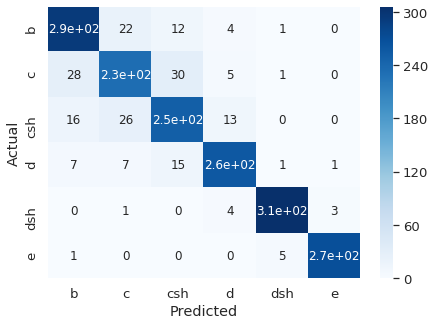

In [243]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.tonic)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

From the confussion matrix we can see that the class with more prediction errors is c.

It is important also to mention that d, c and csh are confused between them by the algorithm

### How about Deep Learning?

We would often prefer deep learning based architectures when the data size is large. See Andrew Ng's figure from his [Coursera course](https://www.coursera.org/learn/neural-networks-deep-learning/):

<img src=https://raw.githubusercontent.com/mbadry1/DeepLearning.ai-Summary/master/1-%20Neural%20Networks%20and%20Deep%20Learning/Images/11.png width="700">

The data size in our case is small and the methods examplified above are just fine. Below, for the sake of presenting an example using a deep learning architecture, we build (with Keras) and train a DNN using the same features. For cases with larger data sets, feature extraction step can be dropped and end-to-end systems(audio->label) can be designed. Due to the size of our data, we will stick with our features.


In [0]:
from sklearn.preprocessing import StandardScaler

#Let's start by splitting our data 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)
#..and apply normalisation
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

Our neural network will have 4 neurons at the output layer each of which will output the estimated probability of the sample belonging to a class. So, let's convert our labels to **one-hot encoding** to fit to that representation.
Example: a sample belonging to the 'violin' class is represented with 3 (integer encoded) will be represented with  [0 0 0 1]. Similarly, a 'ebclar' sample represented with with 0 will be represented with [1 0 0 0]

In [40]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (4396, 6)
One-hot encoded y_test shape =  (1100, 6)


**Let's define our deep learning architecture**

In [41]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layyer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 6))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train.shape[1])

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


You can have a look at the summary of the model

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (BatchNormalizati (None, 164)               656       
_________________________________________________________________
HiddenLayer_1 (Dense)        (None, 40)                6600      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40)                160       
_________________________________________________________________
activation_1 (Activation)    (None, 40)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
HiddenLayer_2 (Dense)        (None, 20)                820       
_________________________________________________________________
batch_normalization_2 (Batch (None, 20)               

Let's pick an optimizer, compile the model and train the network

In [43]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 50, epochs = 250, validation_split=0.2, verbose=0,)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Testing the trained model

In [44]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1855584961717779
Test accuracy: 0.9215151405334473


It is a good and common practice to check the learning curves

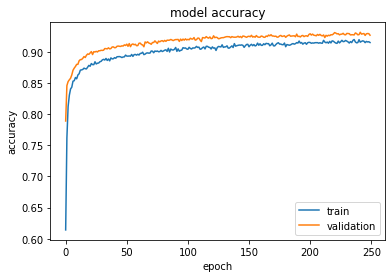

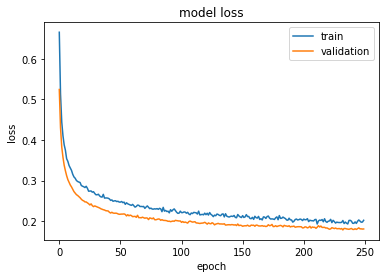

In [45]:
# summarize history for accuracy
plt.plot(summary.history['acc'])
plt.plot(summary.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Conclusion

To sum up, in the **preprocessing** we have clean the file by:
- Cleaning the excerpt from noise
- Deleting high frequency components due to the attack

After the preprocessing we **train** an SVM where we apply:
- Hyperparameter cross validation for gamma
- 10-fold cross validation for the model

We also train a NN with two hidden layer of 40 and 20 neurons respectively.

The results are the following:

| Method | Mean Acurracy (10-fold CV) | Best Accuracy |
| --- | --- | --- |
| SVM| 76.92 % | 88.25% |
| NN| - | 92.15 %|

Therefore, we do not achieve very good results for SVM, while we obtain a better performance with a NN.

### Future work
To improve the model, more analysis in the results obtained by the model should be done, in order to have a better understanding of the errors obtained.

However, a possible option is due to the existance in the dataset of non-pitched percussive instruments, which should be deleted from the dataset.